## Brief intro to datasets 

For this situtation we will analize tweets (or "xs")

In [ ]:
from datasets import list_datasets

In [ ]:
all_datasets = list_datasets()
print(f"All datasets {len(all_datasets)}")
print(f"first 10 are: {all_datasets[:10]}")

In [2]:
## No error

from huggingface_hub import HfApi

api = HfApi()

datasets_generator = api.list_datasets()

datasets = [x for x in datasets_generator]

first = [x.id for x in datasets[:10]]

print(f"All datasets {len(datasets)}")
print(f"first 10 are: {first}")


All datasets 62757
first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

In [4]:
emotions = load_dataset('emotion')
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
## getting a dataste from a url (not found file)
dataset_url = 'https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt'
!wget {dataset_url}

In [7]:
#now using pandas
import pandas as pd

In [8]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
# getting the label name
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## exploratory data analysis

Before training a classification model we need first to know how the data is, a skewed dataset may require different treatment in terms of training loss and evaluation metrics

In [17]:
import matplotlib.pyplot as plt

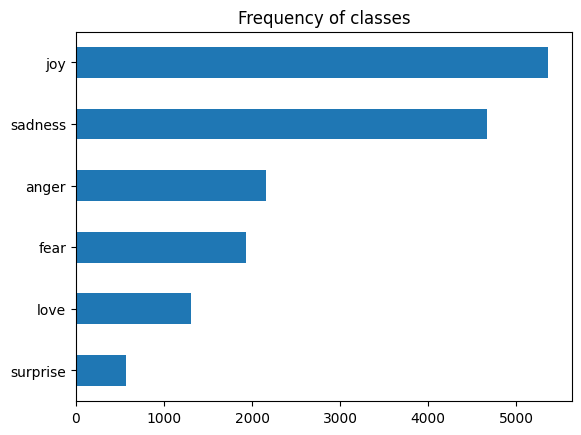

In [18]:
df.label_name.value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()

For this imbalaced situation is recomendable to balanced the dataset. For now we used the raw data

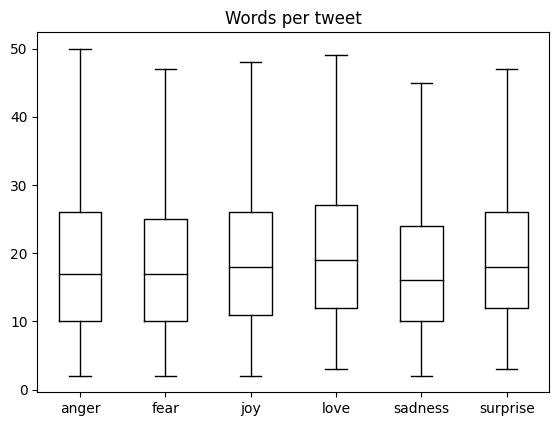

In [19]:
# for now we considering a word as a token

df['Words per tweet'] = df.text.str.split().apply(len)
df.boxplot(
    'Words per tweet', by="label_name", grid=False,
    showfliers=False, color='black'
)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [20]:
# to proceed to make tokens return the original format
emotions.reset_format()

## From text to tokens

#### Character tokenization

In [ ]:
## a single tokenization example
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

In [ ]:
## set character toa  unique item
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

In [ ]:
## transform the tokenized text to a list of integers, related with unique id
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

In [21]:
## creating one hot encoders for tokenizers
import torch

In [22]:
import torch.nn.functional as F

In [ ]:
input_ids = torch.tensor(input_ids)
one_hot_encoding = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encoding.shape

In [ ]:
# verify that the encode is in the indicated position
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encoding[0]}")

#### Word Tokenization

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

#### Subword tokenization

In [23]:
## bert and distilbert uses WordPiece method to tokenize
from transformers import AutoTokenizer

In [24]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

In [ ]:
## converting Id's into tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

In [25]:
## vocabulary size
tokenizer.vocab_size

30522

In [26]:
## max context size
tokenizer.model_max_length

512

#### tokenizing the full dataset

In [27]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [28]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# there are new columns on the emotions
print(emotions_encoded["train"].column_names)

Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-f70ea0aba2a29135.arrow
Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-654bf45943931604.arrow
Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-878cb527c5d76984.arrow


['text', 'label', 'input_ids', 'attention_mask']


In [30]:
print(emotions_encoded["train"][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## training a text classifier

#### Transformers as a Feature extractors

In [31]:
## features extractors only train on the hidden states and do not modify
# the pretained model
from transformers import AutoModel

In [32]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
## extract the last hidden states
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt')
print(f"input tensor shape: {inputs['input_ids'].size()}")
#[batch_size, n_tokens]

In [ ]:
inputs

In [ ]:
# put  it on the same device as the model
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

In [ ]:
# examining last hidden state 
outputs.last_hidden_state.size()
## [batch_size, n_tokens, hidden_dim]

In [ ]:
## hidden state for a single string
outputs.last_hidden_state[:, 0].size()

In [33]:
## extracting the last hidden state of the whole dataset
# by creating a new hidden state column that stores the vector 
def extract_hidden_states(batch):
    # place it in a GPU, if the items are on the model inputs
    inputs = {
        k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names
    }

    # extract the last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return the [CLS] token
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}
    

In [34]:
# converting encodes torch format
emotions_encoded.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)

In [39]:
# for GTX1650 4gb GPU we need to optimized batch size
emotions_hidden = emotions_encoded.map(
    extract_hidden_states, batched=True, batch_size=200)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
## we can print the available GPU memory

# Get the total amount of GPU memory
total_memory = torch.cuda.get_device_properties(device).total_memory

# Get the amount of GPU memory that is currently allocated
allocated_memory = torch.cuda.memory_allocated(device)

# Get the amount of GPU memory that is still free
free_memory = total_memory - allocated_memory

print("Total memory:", round(total_memory / (1024^2), 0))
print("Allocated memory:", round(allocated_memory / (1024^2), 0))
print("Free memory:", round(free_memory / (1024^2), 0))

Total memory: 4185809.0
Allocated memory: 2085108.0
Free memory: 2100701.0


In [42]:
import numpy as np

In [43]:
# creating feature matrix
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing training set

In [46]:
## to visualize we need to reduce the dimensions to 2D using UMAP and
# scaled the vectors to [0,1]
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [51]:
# scaling the features 
X_scaled = MinMaxScaler().fit_transform(X_train)
# init and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DF 2D embedding for visualization
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.365486,6.465873,0
1,-2.971200,5.334569,0
2,5.442331,2.909720,3
3,-2.293909,2.724059,2
4,-3.120718,3.316226,3


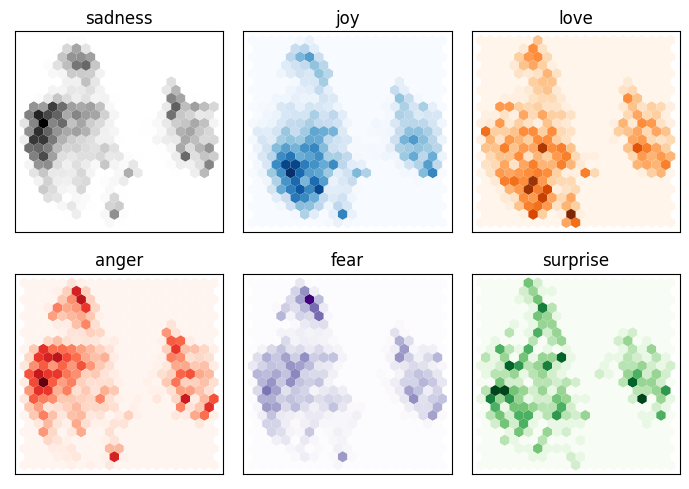

In [53]:
## exploration of density points for each category
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
        gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### training a simple classifier

In [54]:
## we will use an example using logistic regression
from sklearn.linear_model import LogisticRegression

In [55]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [56]:
## using dummy classifier we can see the performance of the baseline model
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [57]:
## generating the cnfusion matrix for our classifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("normalized confusion matrix")
    plt.show()

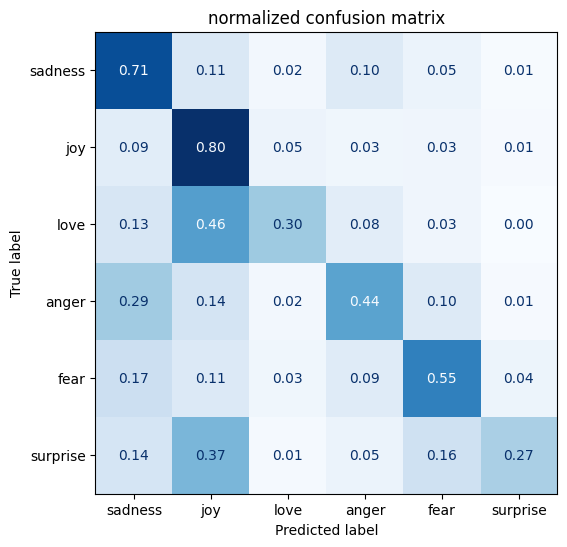

In [58]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)